In [1]:
import os
import sys
import subprocess
root = "/data/luojaa/eukgen/"
%cd {root}
sys.path.append(root)
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#import altair_saver

import ete3
from ete3 import Tree, TreeStyle, TextFace

from core_functions.microcosm_functions import color_tree, tree_analysis
from core_functions.altair_plots import plot_alignment, plot_cumsum_counts
from core_functions.tree_functions import get_outlier_nodes_by_lognorm

#disable altair max rows
alt.data_transformers.disable_max_rows()
#get default altair style'
%run /data/luojaa/eukgen/styling_and_visualisation.py

#dont wrap text output from cells
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

/vf/users/luojaa/eukgen


/tmp/ipykernel_2896938/1593980000.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
os.environ['QT_QPA_PLATFORM']='offscreen'

### read in microcosm_dl files

In [3]:
ec_koginfo = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
ec_koginfo["EC_single"] = ec_koginfo["EC"].apply(lambda x: x.split("|"))
ec_koginfo = ec_koginfo.explode("EC_single")
ec_2kog = ec_koginfo[ec_koginfo.EC_single != "none" ].loc[:,["kogid", "name", "EC_single"]]
ec_2kogs = ec_2kog.groupby("EC_single")["kogid"].apply(lambda x: "|".join(set(x))).reset_index().rename(columns={"EC_single":"EC","kogid":"KOGS"})

ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)

In [99]:
tree_data_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_final_tree_data.tsv", sep = "\t").dropna()
tree_data_dl["EC"] = tree_data_dl.tree_name.apply(lambda x: x.split("_")[0])
dl_annot = pd.read_csv("/data/luojaa/eukgen/microcosm/repseq.microcosms.tmp.tsv", sep = "\t").drop("domain", axis = 1).rename(columns = {"Query":"euk_clade_rep"})

ec_descriptions = pd.read_csv("/data/luojaa/microcosm_metadata/brenda_ec_mappings.tsv", sep = "\t")
ec_info = pd.merge(ec_2kogs, ec_descriptions, on="EC", how="right").drop("comments", axis=1)
tree_data_dl_mapped = pd.merge(tree_data_dl, dl_annot, on=["euk_clade_rep", "EC"], how="left")
tree_data_dl_mapped = pd.merge(tree_data_dl_mapped, ec_info, on="EC", how="left")
tree_data_dl_mapped.fillna("None", inplace=True)
tree_data_dl_mapped = tree_data_dl_mapped.set_index("tree_name")

### read in microcosm files

In [5]:
tree_data = pd.read_csv("/data/luojaa/eukgen/microcosm/final_data/tree_data_merged.tsv", sep = "\t").set_index("tree_name").dropna(axis=1)

In [6]:
# not all microcosms are annotated, and not all annotated clusters made it to microcosms
kegg_annot = pd.read_csv("/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv", sep = "\t")
annotated_clusters = set(kegg_annot.Query)
tree_data_annot = tree_data[tree_data.index.isin(annotated_clusters)].reset_index()

In [7]:
# map KOG annotations and EC annotations to tree data
tree_data_annot_tmp = tree_data_annot.set_index("tree_name")
kegg_annot_tmp = kegg_annot.set_index("Query")[["Target", "Score", "Description", "Pairwise_cov"]]
tree_data_mapped = pd.merge(tree_data_annot_tmp, kegg_annot_tmp, left_index= True, right_index= True, how= "left")#.drop("Unnamed: 0", axis = 1)
tree_data_mapped_tmp = tree_data_mapped.reset_index().set_index("Target")
ec_2kog_tmp = ec_2kog.set_index("kogid")
tree_data_mapped = pd.merge(tree_data_mapped_tmp, ec_2kog_tmp, how = "left", left_index = True, right_index = True).reset_index().fillna("None").rename(columns={"EC_single":"EC"}).set_index("tree_name")
# tree_data_tophits = tree_data_mapped.sort_values(["euk_clade_rep", "Score"], ascending = False).drop_duplicates(["euk_clade_rep", "prok_clade_rep"])

# compare UC and DL microcosms

In [8]:
microcosm_uc_path = '/data/luojaa/eukgen/processing/new_microcosm/'
microcosm_dl_path = '/data/luojaa/eukgen/processing/microcosm_dl_final/'

In [9]:
def remove_hgt(df):
    return df[(df['c-ELW'].between(0.4, 1))
              & ~((df['c-ELW'].between(0.99, 1) & (df.prok_taxa != 'Asgard')))
              & ((df['deltaL'] != -1) | (df.prok_taxa == 'Asgard'))
              & (df.euk_LCA.isin(['Eukaryota', 'cellular organisms']))
              & (df.euk_scope_len > 5)]

In [71]:
trees_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.final.tsv", sep = "\t")
trees_dl_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.final.tsv", sep = "\t")

# map the new taxa onto the old microcosm df
old2new_taxa = trees_dl_cELW.groupby("tree_name")["prok_taxa"].agg(lambda x: ",".join(set(x))).to_dict()
def map_old2new(ec_kog):
    try:
        return old2new_taxa[ec_kog]
    except KeyError:
        return "None"
        # try:
        #     ec_kog = ec_kog.split("_")[0] + "_None"
        #     return old2new_taxa[ec_kog]
        # except KeyError:
        #     return "None"
        
trees_cELW["prok_taxa_new"] = trees_cELW.EC_KOG.apply(lambda x: map_old2new(x))

# # reverse mapping, old onto new
# new2old_taxa = trees_cELW.groupby("EC_KOG")["prok_taxa"].agg(lambda x: ",".join(set(x))).to_dict()
# # new_tids = set(trees_dl_cELW.tree_name)
# # new_none2old_taxa = {}
# # for old_taxa in new2old_taxa.keys():
# #     if old_taxa not in new_tids:
# #         ec_none = old_taxa.split("_")[0] + "_None"
# #         new_none2old_taxa[ec_none] = new2old_taxa[old_taxa]

# def map_new2old(ec_kog):
#     try:
#         return new2old_taxa[ec_kog]
#     except KeyError:
#         return "None"
#         # try:
#         #     return new_none2old_taxa[ec_kog]
#         # except KeyError:
#         #     return "None"
# trees_dl_cELW["prok_taxa_old"] = trees_dl_cELW.tree_name.apply(lambda x: map_new2old(x))

trees_cELW, trees_dl_cELW = remove_hgt(trees_cELW), remove_hgt(trees_dl_cELW)

In [73]:
trees_cELW_beta = trees_cELW[trees_cELW.prok_taxa_new.str.contains("Betaproteobacteria")]
trees_dl_cELW_beta = trees_dl_cELW[trees_dl_cELW.prok_taxa == "Betaproteobacteria"]

In [87]:
trees_cELW_beta[trees_cELW_beta.tree_name == system]

tree_name   euk_clade_rep  euk_clade_size  euk_clade_weight  \
348   EP00825P051850  WP_218970369_1              31          0.297673   
5519  EP00825P051850  EP00582P014531              26          0.426036   
5520  EP00825P051850  EP00582P014531              26          0.426036   

      euk_leaf_clade             euk_LCA  \
348            False  cellular organisms   
5519           False  cellular organisms   
5520           False  cellular organisms   

                                              euk_scope  euk_scope_len  \
348   Ochrophyta|Chlorophyta|Euglenida|Streptophyta|...              9   
5519  Rhizaria|Metazoa|Ochrophyta|Euglenida|Colpodel...              8   
5520  Rhizaria|Metazoa|Ochrophyta|Euglenida|Colpodel...              8   

           prok_clade_rep  prok_clade_size  ...   p-AU  p-AU_accept  Target  \
348        WP_137048144_1                8  ...  0.666            +  K07511   
5519  JAHQWS010000254.1_1                6  ...  0.527            +  K07511   
5520       WP_137048144_1                8  ...  0.582            +  K07511   

      Score                        Description  Pairwise_cov        EC  \
348   364.5  enoyl-CoA hydratase [EC:4.2.1.17]      0.578947  4.2.1.17   
5519  364.5  enoyl-CoA hydratase [EC:4.2.1.17]      0.578947  4.2.1.17   
5520  364.5  enoyl-CoA hydratase [EC:4.2.1.17]      0.578947  4.2.1.17   

               EC_KOG  cELW_norm       prok_taxa_new  
348   4.2.1.17_K07511     0.0621  Betaproteobacteria  
5519  4.2.1.17_K07511     0.0403  Betaproteobacteria  
5520  4.2.1.17_K07511     0.0487  Betaproteobacteria  

[3 rows x 38 columns]

In [81]:
trees_cELW_m = trees_cELW_beta
trees_cELW_dl_m = trees_dl_cELW_beta

In [82]:
systems = iter(trees_cELW_m.tree_name.unique())
#systems_dl = iter(trees_cELW_dl_m.tree_name.unique())
len(trees_cELW_m.tree_name.unique())

189

{'K09667': 'protein O-GlcNAc transferase [EC:2.4.1.255]', 'K19002': '1,2-diacylglycerol 3-alpha-glucosyltransferase [EC:2.4.1.337]', 'K13668': 'phosphatidyl-myo-inositol dimannoside synthase [EC:2.4.1.346]', 'K16150': 'glycogen synthase [EC:2.4.1.11]', 'K15521': 'D-inositol-3-phosphate glycosyltransferase [EC:2.4.1.250]', 'K00754': 'L-malate glycosyltransferase [EC:2.4.1.-]', 'K02844': 'UDP-glucose:(heptosyl)LPS alpha-1,3-glucosyltransferase [EC:2.4.1.-]', 'K06338': 'spore coat protein SA', 'K03208': 'putative colanic acid biosynthesis glycosyltransferase WcaI', 'K08256': 'phosphatidyl-myo-inositol alpha-mannosyltransferase [EC:2.4.1.345]', 'K13058': 'mannosylfructose-phosphate synthase [EC:2.4.1.246]', 'K21011': 'polysaccharide biosynthesis protein PelF', 'K12989': 'mannosyltransferase [EC:2.4.1.-]', 'K20999': 'polysaccharide biosynthesis protein PslF', 'K13678': '1,2-diacylglycerol-3-alpha-glucose alpha-1,2-galactosyltransferase [EC:2.4.1.-]', 'K21001': 'polysaccharide biosynthesis p

alt.Chart(...)

Target   euk_clade_rep             euk_LCA  \
tree_name                                                    
EP00277P044854  K09667  EP00811P032481           Eukaryota   
EP00277P044854  K09667  EP00811P032481           Eukaryota   
EP00277P044854  K09667  WP_167738109_1  cellular organisms   
EP00277P044854  K09667  WP_167738109_1  cellular organisms   
EP00277P044854  K09667  WP_167738109_1  cellular organisms   
...                ...             ...                 ...   
EP00277P044854  K14335  EP00811P032481           Eukaryota   
EP00277P044854  K14335  WP_167738109_1  cellular organisms   
EP00277P044854  K14335  EP00811P032481           Eukaryota   
EP00277P044854  K14335  WP_167738109_1  cellular organisms   
EP00277P044854  K14335  WP_167738109_1  cellular organisms   

                                                        euk_scope  \
tree_name                                                           
EP00277P044854                Cryptophyceae|Euglenida|Dinophyceae   
EP00277P044854                Cryptophyceae|Euglenida|Dinophyceae   
EP00277P044854  Cryptophyceae|Amoebozoa|Ochrophyta|Chlorophyta...   
EP00277P044854  Cryptophyceae|Amoebozoa|Ochrophyta|Chlorophyta...   
EP00277P044854  Cryptophyceae|Amoebozoa|Ochrophyta|Chlorophyta...   
...                                                           ...   
EP00277P044854                Cryptophyceae|Euglenida|Dinophyceae   
EP00277P044854  Cryptophyceae|Amoebozoa|Ochrophyta|Chlorophyta...   
EP00277P044854                Cryptophyceae|Euglenida|Dinophyceae   
EP00277P044854  Cryptophyceae|Amoebozoa|Ochrophyta|Chlorophyta...   
EP00277P044854  Cryptophyceae|Amoebozoa|Ochrophyta|Chlorophyta...   

                euk_scope_len  prok_clade_rep            prok_taxa      dist  \
tree_name                                                                      
EP00277P044854              3  WP_036275159_1  Gammaproteobacteria  1.590489   
EP00277P044854              3  WP_042341130_1  Alphaproteobacteria  1.475747   
EP00277P044854             14  WP_036275159_1  Gammaproteobacteria  0.903461   
EP00277P044854             14  WP_042341130_1  Alphaproteobacteria  0.788719   
EP00277P044854             14  WP_153293237_1       Actinomycetota  4.653263   
...                       ...             ...                  ...       ...   
EP00277P044854              3  WP_100997542_1            FCB group  5.710666   
EP00277P044854             14  WP_100997542_1            FCB group  5.682102   
EP00277P044854              3  WP_101894970_1  Gammaproteobacteria  4.366978   
EP00277P044854             14  WP_142089917_1            Bacillota  5.354070   
EP00277P044854             14  WP_101894970_1  Gammaproteobacteria  4.338414   

                top_dist  raw_stem_length  ...  p-SH_accept         c-ELW  \
tree_name                                  ...                              
EP00277P044854       7.0         0.554711  ...            +  4.570000e-01   
EP00277P044854       6.0         0.554711  ...            +  4.380000e-01   
EP00277P044854       5.0         0.196915  ...            +  4.210000e-01   
EP00277P044854       4.0         0.196915  ...            +  3.570000e-01   
EP00277P044854       5.0         2.266390  ...            +  2.220000e-01   
...                  ...              ...  ...          ...           ...   
EP00277P044854      15.0         3.397236  ...            -  1.220000e-24   
EP00277P044854      17.0         3.368672  ...            -  3.960000e-26   
EP00277P044854      13.0         3.397236  ...            -  2.570000e-26   
EP00277P044854      17.0         3.368672  ...            -  6.050000e-29   
EP00277P044854      15.0         3.368672  ...            -  2.030000e-31   

                c-ELW_accept          p-AU  p-AU_accept  Score  \
tree_name                                                        
EP00277P044854             +  6.930000e-01            +  628.0   
EP00277P044854             +  5.370000e-01            +  628.0   
EP00

alt.VConcatChart(...)

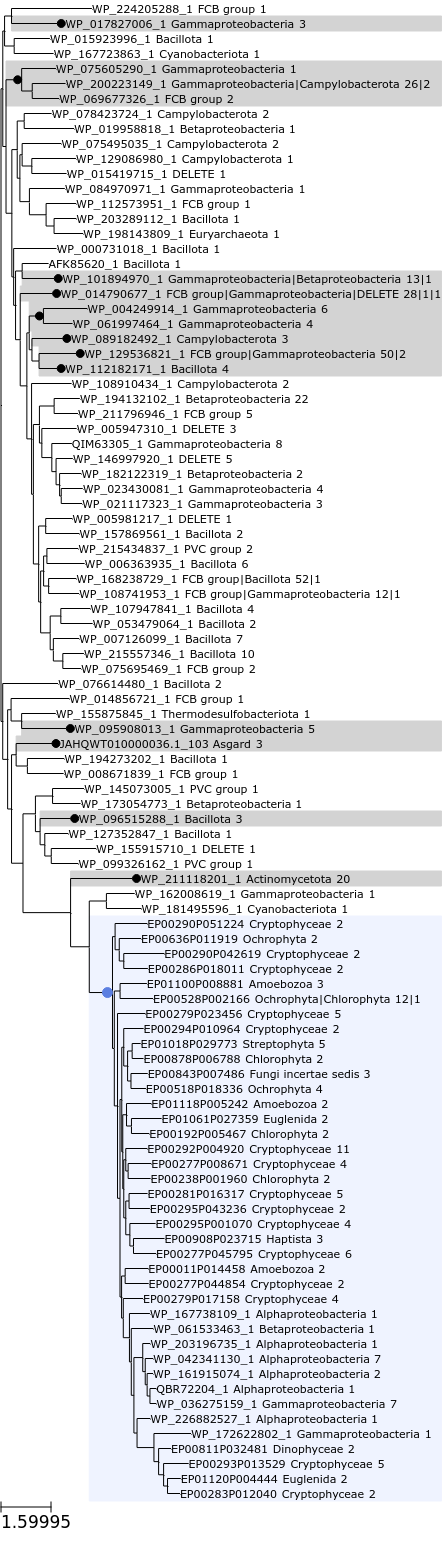

In [101]:
system = next(systems)
run_microcosms(system, False)

['protein O-GlcNAc transferase']
['K09667|K18134']
System 2.4.1.255_K09667 has Eukaryotic clades ['EP00742P010506' 'XP_008913877.1']
/data/luojaa/eukgen/processing/microcosm_dl_final/2.4.1.255_K09667/2.4.1.255_K09667.merged.fasta.muscle.treefile.annot
Tree has 69 leaves


alt.Chart(...)

Unnamed: 0   euk_clade_rep    euk_LCA  \
tree_name                                                 
2.4.1.255_K09667           1  EP00742P010506  Eukaryota   
2.4.1.255_K09667           2  XP_008913877.1  Eukaryota   
2.4.1.255_K09667           3  XP_008913877.1  Eukaryota   
2.4.1.255_K09667           0  EP00742P010506  Eukaryota   

                                                          euk_scope  \
tree_name                                                             
2.4.1.255_K09667  Euglenida|Ancyromonadidae|Amoebozoa|Glaucocyst...   
2.4.1.255_K09667  Metazoa|Streptophyta|Prasinodermophyceae|Chlor...   
2.4.1.255_K09667  Metazoa|Streptophyta|Prasinodermophyceae|Chlor...   
2.4.1.255_K09667  Euglenida|Ancyromonadidae|Amoebozoa|Glaucocyst...   

                  euk_scope_len  prok_clade_rep            prok_taxa  \
tree_name                                                              
2.4.1.255_K09667             10  WP_146329917_1   Betaproteobacteria   
2.4.1.255_K09667              6  WP_068434632_1  Alphaproteobacteria   
2.4.1.255_K09667              6  WP_146329917_1   Betaproteobacteria   
2.4.1.255_K09667             10  WP_068434632_1  Alphaproteobacteria   

                      dist  top_dist  raw_stem_length  ...   p-SH  \
tree_name                                              ...          
2.4.1.255_K09667  0.582430       3.0         0.484351  ...  1.000   
2.4.1.255_K09667  0.604907       3.0         0.339228  ...  0.496   
2.4.1.255_K09667  0.839769       6.0         0.614527  ...  1.000   
2.4.1.255_K09667  1.152492       8.0         0.611514  ...  0.199   

                  p-SH_accept  c-ELW  c-ELW_accept   p-AU p-AU_accept  \
tree_name                                                               
2.4.1.255_K09667            +  0.801             +  0.789           +   
2.4.1.255_K09667            +  0.500             +  0.497           +   
2.4.1.255_K09667            +  0.500             +  0.503           +   
2.4.1.255_K09667            +  0.199             +  0.211           +   

                         EC confidence           KOGS  \
tree_name                                               
2.4.1.255_K09667  2.4.1.255        1.0  K09667|K18134   
2.4.1.255_K09667  2.4.1.255        1.0  K09667|K18134   
2.4.1.255_K09667  2.4.1.255        1.0  K09667|K18134   
2.4.1.255_K09667  2.4.1.255        1.0  K09667|K18134   

                                   description  
tree_name                                       
2.4.1.255_K09667  protein O-GlcNAc transferase  
2.4.1.255_K09667  protein O-GlcNAc transferase  
2.4.1.255_K09667  protein O-GlcNAc transferase  
2.4.1.255_K09667  protein O-GlcNAc transferase  

[4 rows x 28 columns]

alt.VConcatChart(...)

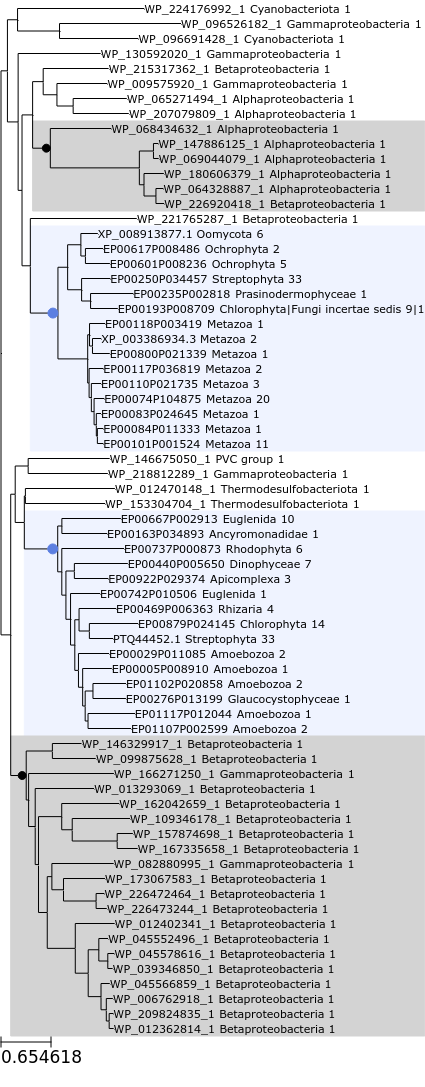

In [ ]:
system_dl = trees_cELW_m[trees_cELW_m.tree_name == system].EC_KOG.iloc[0]
run_microcosms(system_dl, True)

In [95]:
trees_dl_cELW[trees_dl_cELW.tree_name=='4.2.1.17_K07511']

tree_name  Unnamed: 0   euk_clade_rep  euk_clade_size  \
2397  4.2.1.17_K07511          26  EP01097P008187             348   

      euk_clade_weight  euk_leaf_clade    euk_LCA  \
2397          0.850856           False  Eukaryota   

                                              euk_scope  euk_scope_len  \
2397  Haptista|Amoebozoa|Rhizaria|Ciliophora|Chlorop...             16   

      prok_clade_rep  ...  p-SH  p-SH_accept  c-ELW c-ELW_accept   p-AU  \
2397  WP_029578124_1  ...   1.0            +  0.542            +  0.872   

      p-AU_accept        EC  confidence  \
2397            +  4.2.1.17      0.9485   

                                                   KOGS          description  
2397  K01715|K01782|K15016|K13767|K01825|K01692|K075...  enoyl-CoA hydratase  

[1 rows x 35 columns]

In [98]:
f = tree_data_dl_mapped.loc[['4.2.1.17_K07511']].sort_values(by=['c-ELW'], ascending=False)
tree_data_dl_mapped[tree_data_dl_mapped.euk_clade_rep=='EP01097P008187']

Empty DataFrame
Columns: [euk_clade_rep, euk_clade_size, euk_clade_weight, euk_leaf_clade, euk_LCA, euk_scope, euk_scope_len, prok_clade_rep, prok_clade_size, prok_clade_weight, prok_leaf_clade, prok_taxa, dist, top_dist, raw_stem_length, median_euk_leaf_dist, stem_length, logL, deltaL, bp-RELL, bp-RELL_accept, p-KH, p-KH_accept, p-SH, p-SH_accept, c-ELW, c-ELW_accept, p-AU, p-AU_accept, EC, confidence, KOGS, description]
Index: []

[0 rows x 33 columns]

In [16]:
def run_microcosms(system, isdl):
    if isdl:
        microcosm_path = microcosm_dl_path
        data = tree_data_dl_mapped.loc[[system]].sort_values(by=['c-ELW'], ascending=False)
        print(data.description.unique())
        print(data.KOGS.unique())
    else:
        microcosm_path = microcosm_uc_path
        data = tree_data_mapped.loc[[system]].sort_values(by=['Score','c-ELW'], ascending=False)
        kogs, functions = data.Target, data.Description
        print(dict(zip(kogs, functions)))
        
    clades = data.euk_clade_rep.unique()
    print(f'System {system} has Eukaryotic clades {clades}')
    
    clade = clades[0]
    
    plot_data = data[data.euk_clade_rep == clade]
    
    dist_bar = alt.Chart(data, title=f'{system}: {clade}').mark_bar().encode(
        x = alt.X('prok_taxa', sort=None, axis=alt.Axis(labelAngle=-45)),
        y = alt.Y('top_dist'),
        color = alt.Color('prok_taxa:O'),
        tooltip = alt.Tooltip(['top_dist', 'prok_clade_weight', 'prok_clade_size', 'prok_clade_rep', 'prok_leaf_clade'])
    )
    
    print(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
    tree = Tree(f'{microcosm_path}{system}/{system}.merged.fasta.muscle.treefile.annot')
    annot_tree, tree_img = color_tree(tree, view_in_notebook=True)
    
    
    from core_functions.altair_plots import plot_alignment
    aln_file = f'{microcosm_path}{system}/{system}.merged.fasta.muscle'
    
    #leaf_names = [leaf.name for leaf in trees[system].get_leaves()]
    leaf_names = [leaf.name for leaf in tree.get_leaves()]
    
    plot, aln_data = plot_alignment(aln_file, seqlimit=100, plot_range=(0,300), label_order=leaf_names)
    
    \
    print(f'Tree has {len(leaf_names)} leaves')
    display(dist_bar)
    display(data.drop(["euk_clade_size","euk_clade_weight","euk_leaf_clade","prok_clade_size","prok_clade_weight","prok_leaf_clade"], axis=1))#.iloc[:,[0,4,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]])
    #display(pd.DataFrame(CDD_annot.loc[system]))
    display(plot)
    display(tree_img)